# Topic Modeling and LDA Analysis

## Overview

In this notebook we will take a closer look at the terms of service of the companies we analyzed. We will focus on topic modeling for the sections of these documents in order to identify the topic at the section level and better understand the structure of these documents.

In [160]:
import os
import re
import string
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

import gensim
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

%matplotlib inline

## Data Loading

To analyze the topics contained in the terms of service of all of these companies, we first need to divide each document into sections. Most have headings or numbers that separate each section, so we will use this and as a fallback we will separate the text by their line breaks.

This will enable us to assign a topic to each section contained in the terms of service and analyze the topics contained for each kind of company

In [161]:


# load companies
df = pd.read_csv('data/terms_of_service.csv')
df.head()
df.columns  = df.columns.str.lower()

# load tos docs
tos = {}
for dirname, _, filenames in os.walk('data/companies'):
    for filename in filenames:
        company_name = filename.split('.')[0]
        with open(os.path.join(dirname, filename), 'r', encoding='utf-8') as f:
            tos[company_name] = f.read()

tos_df = pd.DataFrame.from_dict(tos, orient='index', columns=['text'])

In [162]:
def extract_sections_from_tos(text, company_name):
    sections = []
    current_section_title = "Introduction/General Terms" # Default title
    current_section_content_lines = []

    # Patterns
    # 1. Specific "OFFERING DESCRIPTION" headings (ex: Anaconda)
    # 2. Question-based headings (ex: Evernote)
    # 3. All-caps headings (ex: Cohere, Veed, and some in Anaconda/Evernote)
    # 4. Numbered headings (ex: Anaconda and others)
    heading_pattern = re.compile(
        r"^(OFFERING DESCRIPTION:\s+[A-Z\s]+)$|"  
        r"^(?:\s*(?:What|How|Can|Do|Are|Does|Will|Is|Where)\s+.*?\?)$|" 
        r"^(?:\s*[A-Z][A-Z\s;,'&\(\)\.\-]*)$|" 
        r"^(?:\s*\d+\.?\d*(?:\.\d+)*\s+[A-Z].*)$" 
        , re.MULTILINE
    )

    lines = text.split('\n')

    for i, line in enumerate(lines):
        stripped_line = line.strip()
        if not stripped_line: 
            continue

        match = heading_pattern.match(stripped_line)

        is_false_positive_numbered_heading = False
        # Filter list items that start with a number
        leading_number_pattern = r"^\s*\d+\.?\d*(?:\.\d+)*\s+"
        if match and re.match(leading_number_pattern, stripped_line):
            # Split the line by the pattern, removing the number
            parts = re.split(leading_number_pattern, stripped_line, 1)
            if len(parts) > 1:
                content_after_number_prefix = parts[1]
                # Check if the content is not all uppercase
                if not content_after_number_prefix.isupper():
                    lowercase_count = sum(1 for char in content_after_number_prefix if 'a' <= char <= 'z')
                    total_alpha_count = sum(1 for char in content_after_number_prefix if 'a' <= char <= 'z' or 'A' <= char <= 'Z')

                    # If more than 30% of alphabetic characters are lowercase
                    # and the phrase is more than 5 words
                    # we assume is a list item, not a heading
                    if total_alpha_count > 0 and (lowercase_count / total_alpha_count) > 0.3 and len(content_after_number_prefix.split()) > 5:
                        is_false_positive_numbered_heading = True

        if match and not is_false_positive_numbered_heading:
            # If new heading then new section
            if current_section_content_lines:
                sections.append({
                    'company': company_name,
                    'section_title': current_section_title.replace('^ top', '').strip(),
                    'section_text': ' '.join(current_section_content_lines).strip(),
                    'method': 'regex'
                })

            current_section_title = stripped_line 
            current_section_content_lines = []
        else:
            current_section_content_lines.append(stripped_line)

    # Add the last accumulated section after the loop finishes
    if current_section_content_lines:
        sections.append({
            'company': company_name,
            'section_title': current_section_title.replace('^ top', '').strip(),
            'section_text': ' '.join(current_section_content_lines).strip(),
            'method': 'regex'
        })

    # fallback logic 
    lines2 = text.split('\n\n')
    if len(sections) < 5:
        
        sections = [{'company': company_name, 
                     'section_title': text[:10], 
                     'section_text': text,
                     'method': 'split'} for text in lines2 if text.strip() != ""]


    return sections

sections_data = []
for company, text in tos.items():
    sections_data.extend(extract_sections_from_tos(text, company))

sections_df = pd.DataFrame(sections_data).rename(columns={'section_title': 'title', 'section_text': 'text'})
sections_df.head(5)


,company,title,text,method
0,huggingface,Thanks for,Thanks for using Hugging Face and being part o...,split
1,huggingface,We drafted,We drafted the following Terms of Service to m...,split
2,huggingface,Please rea,Please read these Terms carefully as they cont...,split
3,huggingface,Whenever y,Whenever you want to use or purchase the Servi...,split
4,huggingface,In other w,"In other words, these Terms are a binding agre...",split


In [163]:
sections_df.groupby(['company', 'method']).size().sort_values(ascending=False).head(20)

company       method
huggingface   split     108
hootsuite     split      92
elementor     regex      91
reply         split      83
openai        split      73
logicmonitor  split      72
workable      split      71
botpress      regex      69
anyword       split      68
buffer        regex      60
pipedrive     regex      55
otter         regex      55
grammarly     split      55
algolia       regex      53
avoma         split      46
flatfile      split      45
box           regex      44
mailchimp     regex      42
deel          regex      42
ziprecruiter  regex      40
dtype: int64

In [164]:
sections_df = pd.merge(df, sections_df, left_on='company', right_on='company', how='left')

df = pd.merge(df, tos_df, left_on='company', right_index=True)

sections_df.head()

,company,ai pricing model,category,employees,url,title,text,method
0,activtrak,Tiered,Human Resources & Legal,101-1000,https://www.activtrak.com/website-terms-of-use/,The follow,The following terms and conditions (“Website T...,split
1,activtrak,Tiered,Human Resources & Legal,101-1000,https://www.activtrak.com/website-terms-of-use/,BY AGREEIN,"BY AGREEING TO THESE WEBSITE TERMS OF USE, EXC...",split
2,activtrak,Tiered,Human Resources & Legal,101-1000,https://www.activtrak.com/website-terms-of-use/,We Pro,We Provide Our Website For Your Convenienc...,split
3,activtrak,Tiered,Human Resources & Legal,101-1000,https://www.activtrak.com/website-terms-of-use/,Enforc,Enforcement of this Section 6 is solely at...,split
4,activtrak,Tiered,Human Resources & Legal,101-1000,https://www.activtrak.com/website-terms-of-use/,FOLLOW,FOLLOW THE INSTRUCTIONS BELOW IF YOU WISH ...,split


In [165]:
df.groupby('category').agg(num_companies=('company', 'nunique'))

,num_companies
category,
Analytics,4
Artificial Intelligence,15
Collaboration & Productivity,17
Cybersecurity & IT Management,4
Design & Development,10
Financial & Accounting,1
Human Resources & Legal,8
Marketing & Sales,15
Project Management & Maintenance,8


## Data Preprocessing


In [166]:
stop_words = set(stopwords.words('english'))
# Add company names as stopwords
stop_words.update(set(df['company'].str.lower().tolist()+['hugging face']))
stop_words.update(['shall', 'content', 'customer', 'account', 'fee', 'software'])

def clean_text_for_lda(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    
    # remove urls
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'www\.[a-zA-Z0-9-]+\.[a-zA-Z]{2,3}(?:/[^/ \t\n\r\f\v]*)?', '', text)
    text = re.sub(r'\b[a-zA-Z0-9-]+\.(com|org|net|io|co|uk|us|ca|gov|edu|info|biz|dev|app|blog)\b', '', text)

    text = text.replace('and/or', '')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+|[\r\n\t]+|[—–’“”‘]', ' ', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

lemmatizer = WordNetLemmatizer()

from nltk.corpus import wordnet
from nltk import pos_tag
import nltk
nltk.download('averaged_perceptron_tagger_eng')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

def tokenize_and_process(text):
    tokens = []
    preprocessed_tokens = simple_preprocess(text, deacc=True)
    tagged_tokens = pos_tag(preprocessed_tokens)

    for token, tag in tagged_tokens:
        if token not in stop_words and len(token) > 2:
            wordnet_pos = get_wordnet_pos(tag)
            lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
            tokens.append(lemma)
    return tokens

df['cleaned_text'] = df['text'].apply(clean_text_for_lda)
df['tokens'] = df['cleaned_text'].apply(tokenize_and_process)
df['cleaned_text'] = df['text'].apply(clean_text_for_lda)

sections_df['cleaned_text'] = sections_df['text'].apply(clean_text_for_lda)
sections_df['tokens'] = sections_df['cleaned_text'].apply(tokenize_and_process)
sections_df['cleaned_text'] = sections_df['text'].apply(clean_text_for_lda)


df.head()

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sergiocarcamo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


,company,ai pricing model,category,employees,url,text,cleaned_text,tokens
0,activtrak,Tiered,Human Resources & Legal,101-1000,https://www.activtrak.com/website-terms-of-use/,The following terms and conditions (“Website T...,the following terms and conditions website ter...,"[following, term, condition, website, term, us..."
1,aftership,Tiered,Supply Chain & Logistics,101-1000,https://www.aftership.com/legal/terms-of-servi...,We may update these Terms from time to time an...,we may update these terms from time to time an...,"[may, update, term, time, time, may, notify, u..."
2,aha,Addon,Project Management & Maintenance,101-1000,https://www.aha.io/legal/terms_of_service,We'll try to make this as painless as possible...,well try to make this as painless as possible ...,"[well, try, make, painless, possible, reality,..."
3,aircall,Addon,Collaboration & Productivity,101-1000,https://legal.aircall.io/#contract-rywvrdsmn,If your billing address is located in the Unit...,if your billing address is located in the unit...,"[billing, address, locate, united, state, cana..."
4,algolia,Tiered,Design & Development,101-1000,https://www.algolia.com/policies/terms,THESE TERMS OF SERVICE (THESE “TERMS”) GOVERN ...,these terms of service these terms govern subs...,"[term, service, term, govern, subscription, us..."


## Topic Modeling using LDA



In [179]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

processed_docs = sections_df['tokens'].tolist()
dictionary_gensim = Dictionary(processed_docs)

dictionary_gensim.filter_extremes(no_below=2, no_above=0.95)

corpus_gensim = [dictionary_gensim.doc2bow(doc) for doc in processed_docs]

STEP_SIZE=1
START=4
LIMIT=25


In [176]:
perplexity_values = []
coherence_values_cv = [] 
model_list = []

print("Calculating perplexity and coherence for different numbers of topics...")
for num_topics in range(START, LIMIT, STEP_SIZE):

    print(f"Training LDA with num_topics={num_topics}...")
    lda_model_perplexity = LdaModel(
        corpus=corpus_gensim,
        id2word=dictionary_gensim,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto',
        eta='auto'
    )

    perplexity = lda_model_perplexity.log_perplexity(corpus_gensim)
    perplexity_values.append(np.exp(-1. * perplexity))
    

    coherence_model_lda_cv = CoherenceModel(
        model=lda_model_perplexity,
        texts=processed_docs,
        dictionary=dictionary_gensim,
        coherence='c_v'
    )

    model_list.append(lda_model_perplexity)
    coherence_values_cv.append(coherence_model_lda_cv.get_coherence())

    print(f"Num Topics: {num_topics}, Perplexity: {perplexity_values[-1]:.4f}, Coherence (C_v): {coherence_values_cv[-1]:.4f}")



Calculating perplexity and coherence for different numbers of topics...
Training LDA with num_topics=4...
Num Topics: 4, Perplexity: 747.0826, Coherence (C_v): 0.3494
Training LDA with num_topics=5...
Num Topics: 5, Perplexity: 736.7764, Coherence (C_v): 0.3462
Training LDA with num_topics=6...
Num Topics: 6, Perplexity: 720.6319, Coherence (C_v): 0.3528
Training LDA with num_topics=7...
Num Topics: 7, Perplexity: 717.0543, Coherence (C_v): 0.3557
Training LDA with num_topics=8...
Num Topics: 8, Perplexity: 701.9727, Coherence (C_v): 0.3880
Training LDA with num_topics=9...
Num Topics: 9, Perplexity: 702.6165, Coherence (C_v): 0.3940
Training LDA with num_topics=10...
Num Topics: 10, Perplexity: 698.7928, Coherence (C_v): 0.4054
Training LDA with num_topics=11...
Num Topics: 11, Perplexity: 694.2490, Coherence (C_v): 0.3959
Training LDA with num_topics=12...
Num Topics: 12, Perplexity: 702.3340, Coherence (C_v): 0.3963
Training LDA with num_topics=13...
Num Topics: 13, Perplexity: 706.

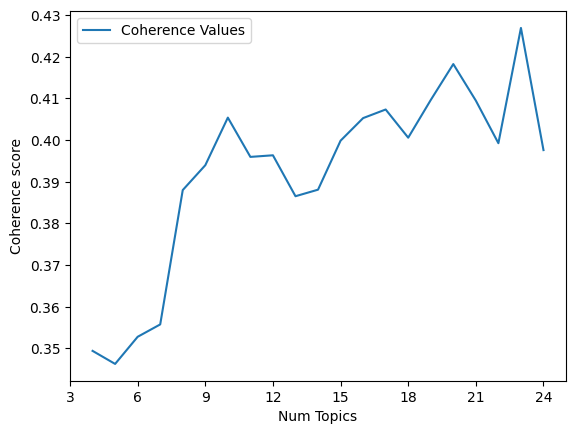

In [203]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


x = range(START, LIMIT, STEP_SIZE)
plt.plot(x, coherence_values_cv)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["Coherence Values"], loc='best')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()


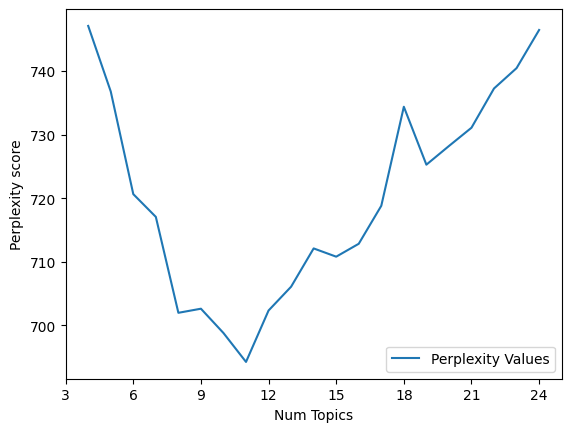

In [202]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



x = range(START, LIMIT, STEP_SIZE)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(["Perplexity Values"], loc='best')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()


In [201]:
data = {
    'Num Topics': x,
    'Perplexity Score': perplexity_values,
    'Coherence Score': coherence_values_cv
}
df_scores = pd.DataFrame(data)
df_scores.set_index('Num Topics', inplace=True)


df_scores.style.background_gradient(subset=['Perplexity Score'], cmap='Greens_r') \
                         .background_gradient(subset=['Coherence Score'], cmap='Greens')


,Perplexity Score,Coherence Score
Num Topics,,
4,747.082622,0.349374
5,736.776362,0.346242
6,720.631908,0.352756
7,717.054254,0.355726
8,701.972656,0.387987
9,702.616466,0.393952
10,698.792829,0.405383
11,694.248966,0.395950
12,702.333991,0.396335


Based on both scores, we chose the number of 10 topics.

In [169]:
import pandas as pd

def display_gensim_topics(gensim_lda_model, gensim_dictionary, num_words=10, include_weights=True):
    topic_data = {}
    for topic_id in range(gensim_lda_model.num_topics):
        top_terms_with_prob = gensim_lda_model.get_topic_terms(topicid=topic_id, topn=num_words)
        words = [gensim_dictionary[term_id] for term_id, prob in top_terms_with_prob]
        
        topic_data[f"topic {topic_id}"] = words
        
        if include_weights:
            weights = [f"{prob:.3f}" for term_id, prob in top_terms_with_prob]
            topic_data[f"topic {topic_id} weights"] = weights

    max_len = max(len(col_data) for col_data in topic_data.values())
    for col_name, col_data in topic_data.items():
        if len(col_data) < max_len:
            topic_data[col_name] = col_data + [None] * (max_len - len(col_data))

    return pd.DataFrame(topic_data)

no_top_words_sklearn = 15

vectorizer_sklearn = CountVectorizer(
    max_df=0.95,
    min_df=2,   
    # ngram_range=(1, 2),
    stop_words='english' 
)

processed_docs = sections_df['tokens'].tolist()
dictionary_gensim = Dictionary(processed_docs)

dictionary_gensim.filter_extremes(no_below=2, no_above=0.95)

corpus_gensim = [dictionary_gensim.doc2bow(doc) for doc in processed_docs]

print(f'Number of unique tokens: {len(dictionary_gensim)}')
print(f'Number of documents: {len(corpus_gensim)}')


number_of_topics_gensim = 10 
lda_gensim = LdaModel(
    corpus=corpus_gensim, 
    id2word=dictionary_gensim, 
    num_topics=number_of_topics_gensim, 
    random_state=42,
    passes=10,
    alpha='auto',
    eta='auto'
)



Number of unique tokens: 4392
Number of documents: 2368


In [170]:
df_gensim_topics = display_gensim_topics(lda_gensim, dictionary_gensim, num_words=15, include_weights=False)
display(df_gensim_topics)

def get_dominant_topic(doc_bow):
    topic_dist = lda_gensim.get_document_topics(doc_bow, minimum_probability=0.0)
    dominant_topic = sorted(topic_dist, key=lambda x: x[1], reverse=True)[0][0]
    return dominant_topic

sections_df['topic_gensim'] = [get_dominant_topic(doc_bow) for doc_bow in corpus_gensim]

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,user,party,service,data,job,term,service,arbitration,service,service
1,job,service,subscription,personal,information,agreement,warranty,dispute,right,use
2,right,liability,payment,process,email,service,use,claim,use,user
3,service,information,fee,use,website,use,provide,may,user,may
4,law,claim,term,processing,contact,party,include,notice,license,access
5,use,use,pay,controller,receive,law,thirdparty,address,include,term
6,advertisement,damage,may,processor,provide,may,site,arbitrator,mean,provide
7,include,confidential,plan,addendum,candidate,right,website,court,may,information
8,information,disclose,termination,provide,may,provision,make,copyright,provide,include
9,data,loss,applicable,information,resume,agree,zoho,agreement,grant,agree


From the top words for each topic we observe some interesting themes emerging from the terms of service. These topics provide a detailed view of the document's content. Based on this information we can name and describe each topic:

- **Topic 0: User & Platform Engagement**: focuses on general user interaction with a `service` or `platform`, including `job` roles, user `right`s, `data` handling, and `advertisement` policies.

- **Topic 1: Legal Liability & Confidentiality**: this topic covers the parties responsibilities, `liability`, `damage`, `loss`, `claim`s, and handling of `confidential` `information` such as non-disclosure.

- **Topic 2: Commercial & Subscription Terms**: covers financial and commercial arrangements like `payment`s, `subscription`s, `fee`s, and `term`s for `termination` and billing.

- **Topic 3: Data Processing & Privacy Compliance**: covers sections on `data` governance, specifically `personal` `data` `processing`, `controller`/`processor` roles, and `privacy` `protection`. Includes clauses such as GDPR/CCPA.

- **Topic 4: Recruitment & Website Information**: Blends `job` recruitment (`candidate`, `resume`) with general `website` interaction, `email`, and `contact` information like career pages.

- **Topic 5: General Contractual Framework**: this seems more of a general `agreement` structure, including fundamental `term`s, `party` involvement, `law`, and `binding` provisions such as governing law clauses. 

- **Topic 6: Service Warranty & Support**: focuses on `service` quality, `warranty` details, what the `service` `provide`s, `thirdparty` interactions, and `availability` (ex: SLAs).

- **Topic 7: Dispute Resolution & Legal Proceedings**: A clear legal topic outlining `dispute` resolution mechanisms, specifically `arbitration`, `claim`s, `court` processes, and `copyright` issues.

- **Topic 8: User Rights & Licensing**: Centers on `user` `right`s, `license`s `grant`ed for `service` `use` or `material`, and potentially `feedback` mechanisms for content usage.

- **Topic 9: Service Access & Usage Scope**: Addresses `access` to a `service` or `application`, general `term`s of `use`, and `time`frames or conditions for `responsible` usage rules.

In [171]:
sections_df['topic_gensim'].value_counts()

topic_gensim
9    574
5    331
2    290
8    278
1    253
7    180
3    176
6    128
4     91
0     67
Name: count, dtype: int64

### Topic Distribution by Company Category Analysis

The topic distribution across company categories, visualized in the bar chart and detailed in the heatmap below, reveals different legal focuses for different business domains as identified by our LDA model.

#### Most prevalent

Topic 9 (Service Access & Usage Scope) is proportionally very large in many categories (e.g., Artificial Intelligence, Collaboration & Productivity with 32% of the categoty, Marketing & Sales), indicating that this topic is used across digital sectors. This suggests a common legal ground for how digital services are provided and consumed.

#### Specialized Focus

* **Financial & Accounting / Supply Chain & Logistics:** These categories show an absence of some topics (such as Topic 0 and Topic 4). This suggests their legal documents are either shorter or primarily focused on core transaction/logistics agreements, with less emphasis on general service terms, privacy, or user rights. Perhaps these companies are more orienten on B2B type of contracts. In particular the financial category displays only 3 of the 10 topics.
* **Human Resources & Legal:** As expected, this category shows a higher proportion of Topic 3 (Data Processing & Privacy Compliance), aligning with its core function of handling personal data.
* **Digital/Service-Oriented Categories (AI, Collaboration, Marketing, Design, Analytics):** These categories show more varied topic distributions, with strong emphasis on Topic 1 (Legal Liability & Confidentiality), Topic 5 (General Contractual Framework), and Topic 9 (Service Access & Usage Scope), reflecting the broad legal documentation necessary for digital products and services. The similarity of the distribution of topics among those sectors is quite interesting.



In [ ]:
topic_mapping = {0: 'User & Platform Engagement',
1: 'Legal Liability & Confidentiality',
2: 'Commercial & Subscription Terms',
3: 'Data Processing & Privacy Compliance',
4: 'Recruitment & Website Information',
5: 'General Contractual Framework',
6: 'Service Warranty & Support',
7: 'Dispute Resolution & Legal Proceedings',
8: 'User Rights & Licensing',
9: 'Service Access & Usage Scope'}

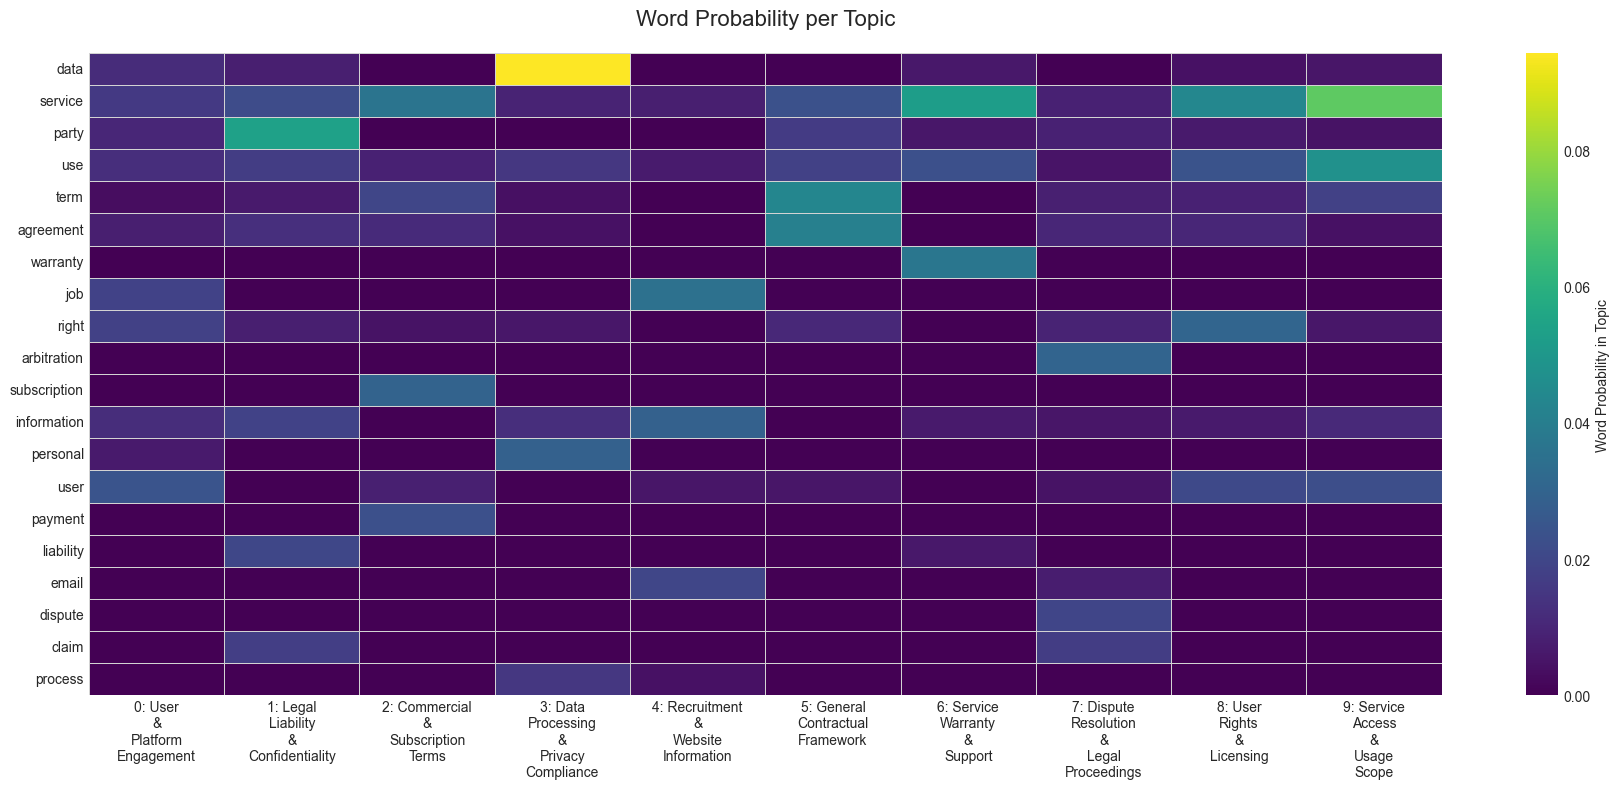

In [304]:
num_words_per_topic_for_heatmap = 3 

all_topic_word_probs = {} 
top_n_words_overall = set() 

for topic_id in topic_mapping.keys():
    words_probs = lda_gensim.show_topic(topic_id, topn=50) 
    
    all_topic_word_probs[topic_id] = {word: prob for word, prob in words_probs}

    for i, (word, prob) in enumerate(words_probs):
        if i < num_words_per_topic_for_heatmap:
            top_n_words_overall.add(word)

unique_words_for_heatmap = sorted(list(top_n_words_overall))

heatmap_data = pd.DataFrame(index=unique_words_for_heatmap, columns=list(topic_mapping.keys()))


for word in unique_words_for_heatmap:
    for topic_id in topic_mapping.keys():
        heatmap_data.loc[word, topic_id] = all_topic_word_probs[topic_id].get(word, 0.0)

heatmap_data = heatmap_data.astype(float) 


heatmap_data['max_prob'] = heatmap_data.max(axis=1)
heatmap_data = heatmap_data.sort_values(by='max_prob', ascending=False).drop(columns='max_prob')


plt.figure(figsize=(18, 8))
sns.heatmap(heatmap_data,
            cmap='viridis',
            annot=False, 
            fmt=".3f", 
            linewidths=.5,
            linecolor='lightgray',
            cbar_kws={'label': 'Word Probability in Topic'}) 

plt.xticks(ticks=np.arange(len(topic_mapping)) + 0.5,
           labels=[f"{id}: {name.replace(' ', '\n')}" for id, name in topic_mapping.items()],
           rotation=0,
           ha='center',
           fontsize=10)

plt.yticks(rotation=0, fontsize=10) # Keep word labels horizontal
plt.xlabel("")
plt.ylabel("")
plt.title("Word Probability per Topic", fontsize=16, pad=20)

plt.tight_layout()
plt.show()



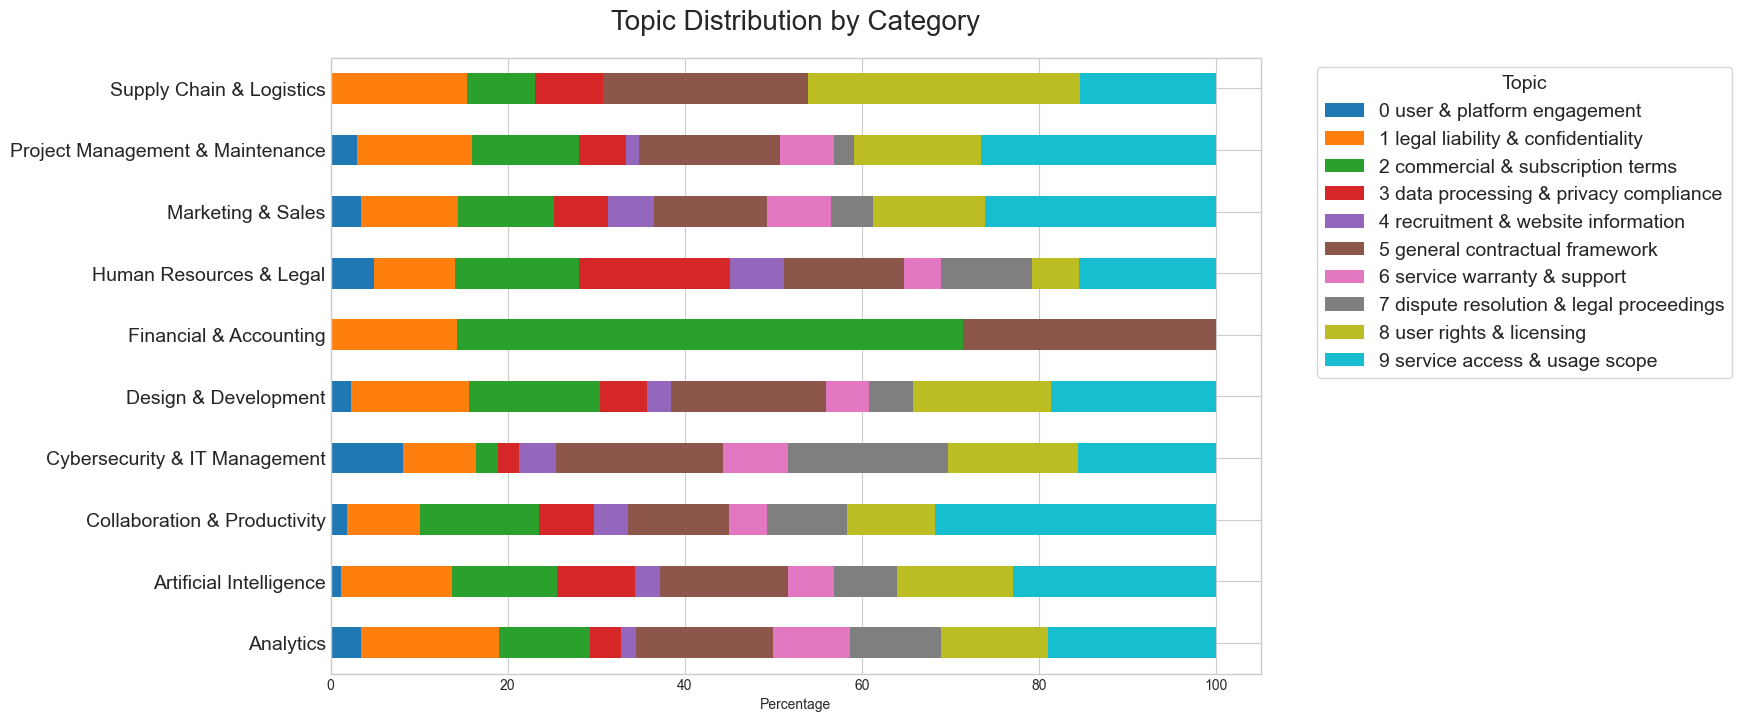

In [266]:
import matplotlib.pyplot as plt
import pandas as pd



grouped_data = sections_df.groupby(['category', 'topic_gensim']).size().unstack()
grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

plt.style.use('seaborn-v0_8-whitegrid') 
plt.figure(figsize=(12, 8))

colors = sns.husl_palette(len(topic_mapping), h=.75, s=.85, l=.65)
colors = sns.color_palette('tab10', n_colors=len(topic_mapping))

grouped_data.plot(kind='barh', stacked=True, color=colors, ax=plt.gca())

plt.xlabel("Percentage")
plt.ylabel("") 
plt.yticks(fontsize=14) 
plt.title("Topic Distribution by Category", fontsize=20,  pad=20)
plt.legend([f'{i} {label.lower()}' for i, label in topic_mapping.items()], 
           title='Topic',
            fontsize=14,
            title_fontsize=14,
            frameon=True, 
            bbox_to_anchor=(1.05, 1), 
            loc='upper left')


plt.show()


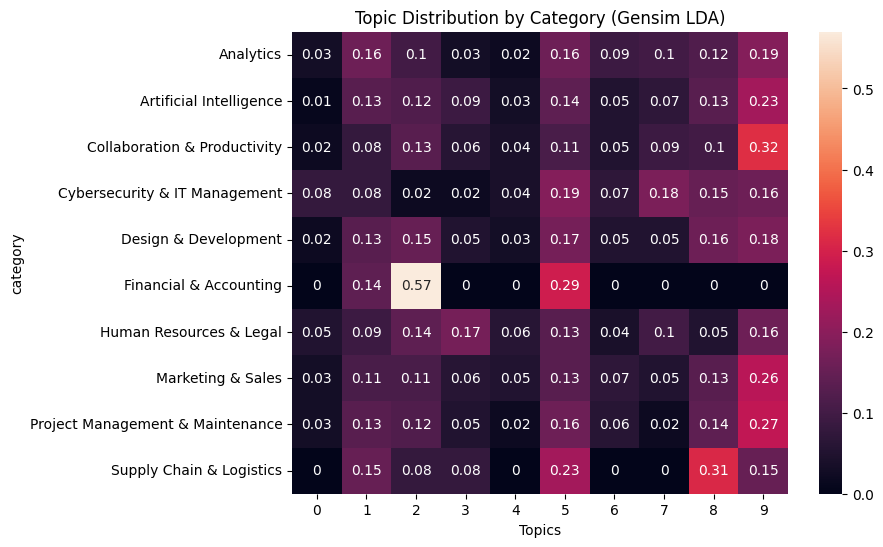

In [157]:
import seaborn as sns

topic_category_dist = sections_df.groupby(['category', 'topic_gensim']).size().unstack(fill_value=0)


plt.figure(figsize=(8, 6))

sns.heatmap(
topic_category_dist.div(topic_category_dist.sum(axis=1), axis=0).apply(lambda x: round(x, 2))
, annot=True
)

plt.title("Topic Distribution by Category (Gensim LDA)")
plt.xlabel("Topics")

plt.show()

## Summary

This LDA topic modeling analysis focused on 10 topics found within the terms of service. These topics range from "User & Platform Engagement" to "Dispute Resolution." 

While "Service Access & Usage Scope" (Topic 9) was widespread, certain categories showed specialized focuses. "Human Resources & Legal" emphasized "Data Processing & Privacy Compliance" (Topic 3), while "Financial & Accounting" and "Supply Chain & Logistics" focused on core agreements, indicating a B2B orientation for these type of companies. Similar topic distributions across digital sectors (AI, Collaboration, Marketing, Design) suggest that there is some common legal requirements for digital products and services and these industries follow this structure.

This analysis provides the groundwork for further analysis of sections of terms on service and could potentially allow companies to compare policies of different supplier or competitors in an easy manner.